In [1]:
%env TF_CPP_MIN_LOG_LEVEL 3
import random
import os
import pathlib
import math
import functools

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

# from skimage import transform
# from skimage import morphology

import train
import config
from model import losses
from train import mkds, compile_model
from dataset_utils import preprocess, auguments


env: TF_CPP_MIN_LOG_LEVEL=3


In [2]:
def gends(ds_root, suffix):
    ds_root = pathlib.Path(ds_root)
    pathlist = ds_root.glob(f"map/*.{suffix}")
    pathlist = sorted([path.name for path in pathlist])
    sat_pathlist = sorted([str(ds_root / "sat" / path) for path in pathlist])
    map_pathlist = sorted([str(ds_root / "map" / path) for path in pathlist])
    test_ds = mkds(sat_pathlist, map_pathlist, batch_size=config.BATCH_SIZE, test=True)
    return test_ds


In [3]:
def show_results(*images, figsize=(20, 20)):
    nb_images = len(images)
    plt.figure(figsize=figsize)
    for idx, image in enumerate(images):
        plt.subplot(1, nb_images, idx + 1)
        plt.imshow(image, cmap="gray")
    plt.show()


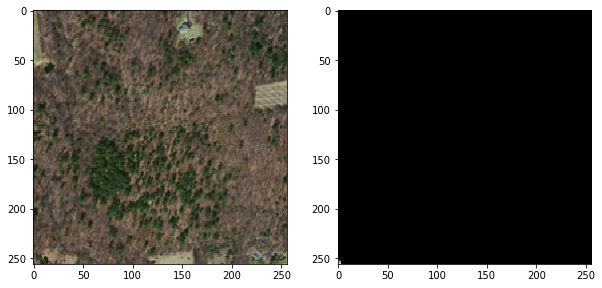

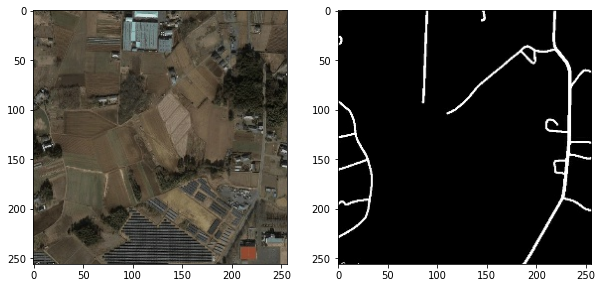

In [4]:
ds_root = "/mass_roads/test/"
suffix = "png"
mr_ds = gends(ds_root, suffix)

mr_inp, mr_tar = next(iter(mr_ds))
show_results(mr_inp[0], mr_tar[0], figsize=(10, 10))


ds_root = "/tokai_katsuta_ds_s17/test/"
suffix = "jpg"
tk_ds = gends(ds_root, suffix)

tk_inp, tk_tar = next(iter(tk_ds))
show_results(tk_inp[0], tk_tar[0], figsize=(10, 10))


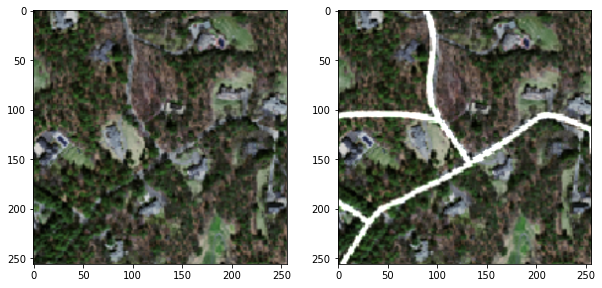

In [5]:
inp_layer = tf.keras.layers.RandomZoom(0.5, seed=1963)
tar_layer = tf.keras.layers.RandomZoom(0.5, seed=1963)

zoomed_inp = inp_layer(mr_inp)
zoomed_tar = inp_layer(mr_tar)
idx = 30
show_results(zoomed_inp[idx], zoomed_inp[idx] + zoomed_tar[idx], figsize=(10, 10))


In [6]:
def eval_model(path, ds):
    loss = losses.DICELoss()
    model = compile_model(loss)
    _ = model.load_weights(path)

    va_loss, va_iou = model.evaluate(ds)
    print("va loss: ", va_loss)
    print("va  iou: ", va_iou)
    return model


In [16]:
eval_model_ds = functools.partial(eval_model, ds=tk_ds)
eval_model_ds = functools.partial(eval_model, ds=mr_ds)


date = "211221"
epoch = "_100"
name = "DA_CM3RFZ-E100-MR-base"
weights_path = f"/results/{date}/checkpoints/{name}/{name}" + epoch
org_model = eval_model_ds(weights_path)


7/7 [==============================] - 1s 85ms/step - loss: 0.3474 - mean_io_u_2: 0.6538
va loss:  0.34738802909851074
va  iou:  0.6537758111953735


7/7 [==============================] - 1s 93ms/step - loss: 0.7704 - mean_io_u_3: 0.5353
va loss:  0.7703574895858765
va  iou:  0.5352687835693359


In [21]:

date = "211222"
epoch = "_100"
name = "DA_CM4RF-E100-tokai17-pret_base"
name = "DA_RF-E100-tokai17-pret_base"
weights_path = f"/results/{date}/checkpoints/{name}/{name}" + epoch
fin_model = eval_model_ds(weights_path)


# date = "211222"
# epoch = "_100"
# name = "DA_CM-E100-tokai-no_pret"
# weights_path = f"/results/{date}/checkpoints/{name}/{name}" + epoch
# nopret_model = eval_model_ds(weights_path)


7/7 [==============================] - 1s 86ms/step - loss: 0.6413 - mean_io_u_8: 0.5638
va loss:  0.6413235664367676
va  iou:  0.563818097114563


(64, 256, 256, 3)
48


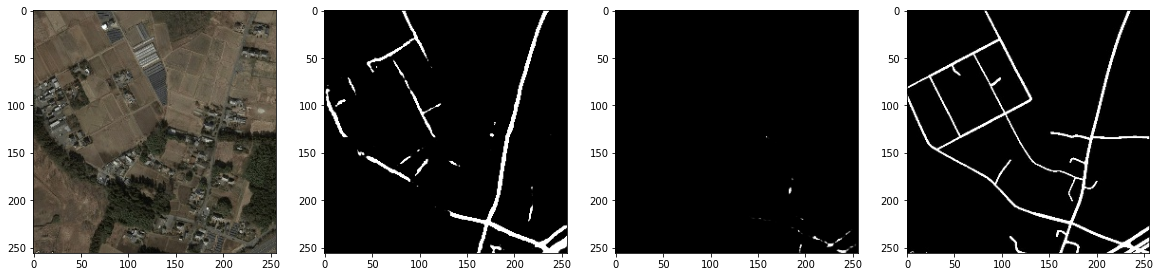

(64, 256, 256, 3)
48


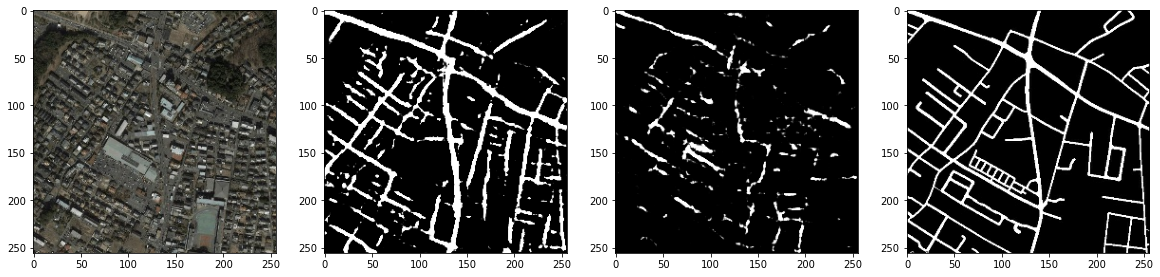

(64, 256, 256, 3)
48


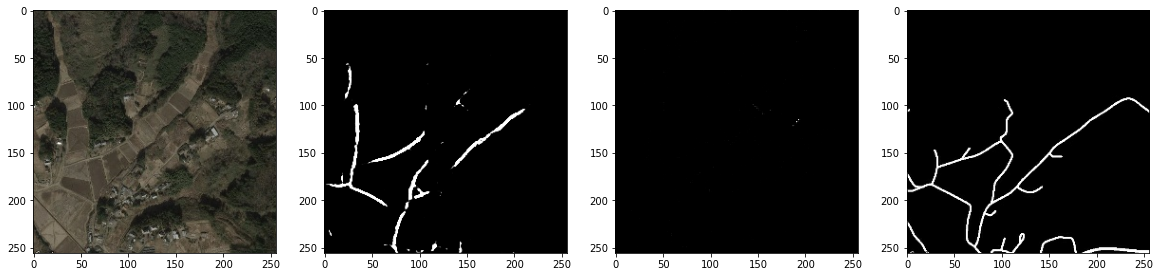

(64, 256, 256, 3)
48


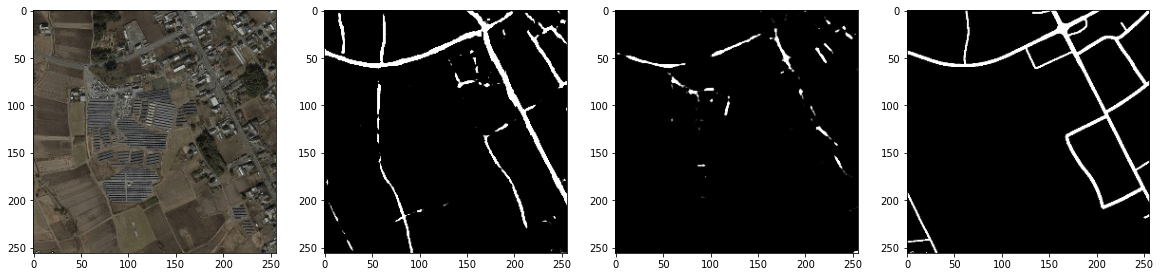

In [22]:
idx = random.randrange(64)
for i, t in tk_ds.take(4):
    print(i.shape)
    print(idx)
    i = i[idx]
    t = t[idx]
    fin_pred = fin_model.predict(i[None])[0]
    # nopret_pred = nopret_model.predict(i[None])[0]
    org_pred = org_model.predict(i[None])[0]
    show_results(i, fin_pred, org_pred, t)


(256, 256, 3)
(256, 256, 1)


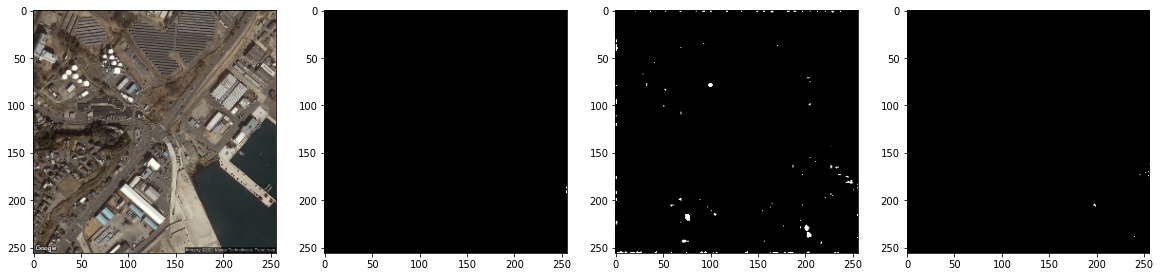

In [29]:
sample_map = cv2.imread("output_map.png")[..., ::-1]
sample_sat = cv2.imread("output_sat.png")[..., ::-1]
sample_sat = cv2.resize(sample_sat, (256, 256))
print(sample_sat.shape)

fin_pred = fin_model.predict(sample_sat[None])[0]
nopret_pred = nopret_model.predict(sample_sat[None])[0]
org_pred = org_model.predict(sample_sat[None])[0]
print(fin_pred.shape)

show_results(sample_sat, fin_pred, nopret_pred, org_pred)